# Toy: AR1 model

Note, you can find the original version of this notebook at [https://github.com/mackelab/sbi/blob/main/tutorials/02_flexible_interface.ipynb](https://github.com/mackelab/sbi/blob/main/tutorials/02_flexible_interface.ipynb) in the `sbi` repository.

## Main syntax

```Python
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

simulator, prior = prepare_for_sbi(simulator, prior)
inference = SNPE(prior)

theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)
```

In [22]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sbi import utils
from sbi import analysis
from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi

seed = 0
torch.manual_seed(seed)

In [24]:
# import torch
# if torch.backends.mps.is_available():
#     mps_device = torch.device("mps")
#     x = torch.ones(1, device=mps_device)
#     print (x)
# else:
#     print ("MPS device not found.")
# prior = torch.distributions.Uniform(torch.tensor([0.0,0.0], device="mps:0"), torch.tensor([1.0,1.0], device="mps:0"))
# inference = SNPE(prior=prior, device="mps:0", density_estimator=neural_posterior)

tensor([1.], device='mps:0')


In [23]:
num_dim = 2
prior = utils.BoxUniform(low=[4.2,0.005], high=[5.8,0.025])

In [24]:
def generate_ar1_time_series(theta):
    time_series = np.zeros(length)
    time_series[0] = x_0
    for t in range(1, length):
        noise = np.random.normal(0, theta[1])
        time_series[t] =  theta[0] * time_series[t - 1]**2 * (1-time_series[t - 1]) + noise
    return time_series

In [25]:
length = 200
x_0 = 0.25
simulator, prior = prepare_for_sbi(generate_ar1_time_series, prior)

In [5]:
# class SummaryNet(nn.Module):
    
#     def __init__(self,
#                  in_channels = (1, 8, 16),
#                  out_channels = (8, 16, 32),
#                  kernel_sizes =  (5, 2, 5), 
#                  padding = (0,0,0),
#                  encoded_space_dim = 3, 
#                  drop_p = 0.5,
#                  act = nn.LeakyReLU,
#                  seq_length = 200,
#                  linear = 10,
#                 ):
#         """
#         Convolutional Network with three convolutional and two dense layers
#         Args:
#             in_channels : inputs channels
#             out_channels : output channels
#             kernel_sizes : kernel sizes
#             padding : padding added to edges
#             encoded_space_dim : dimension of encoded space
#             drop_p : dropout probability
#             act : activation function
#             seq_len : length of input sequences 
#             weight_decay : l2 regularization constant
#             linea : linear layer units
#         """
#         super().__init__()
    
#         # Retrieve parameters
#         self.in_channels = in_channels #tuple of int, input channels for convolutional layers
#         self.out_channels = out_channels #tuple of int, of output channels 
#         self.kernel_sizes = kernel_sizes #tuple of tuples of int kernel size, single integer or tuple itself
#         self.padding = padding
#         self.encoded_space_dim = encoded_space_dim
#         self.drop_p = drop_p
#         self.act = act
#         self.seq_length = seq_length
#         self.linear = linear 
#         self.pool_division = 4
 
      
#         ### Network architecture
#         # First convolutional layer (2d convolutional layer
#         self.first_conv = nn.Sequential(
#             nn.Conv1d(self.in_channels[0], self.out_channels[0], self.kernel_sizes[0], padding=self.padding[0]), 
#             #nn.BatchNorm1d(self.out_channels[0]),
#             self.act(inplace = True),
#             nn.Dropout(self.drop_p, inplace = False),
#             nn.AvgPool1d(self.pool_division)
#         )
        
#         # Second convolution layer
#         self.second_conv = nn.Sequential(
#             nn.Conv1d(self.in_channels[1], self.out_channels[1], self.kernel_sizes[1], padding=self.padding[1]), 
#             #nn.BatchNorm1d(self.out_channels[1]),
#             self.act(inplace = True),
#             nn.Dropout(self.drop_p, inplace = False),
#             nn.AvgPool1d(self.pool_division)
#         )
        
#         # Third convolutional layer
#         self.third_conv = nn.Sequential(
#             nn.Conv1d(self.in_channels[2], self.out_channels[2], self.kernel_sizes[2], padding=self.padding[2]), 
#             #nn.BatchNorm1d(self.out_channels[2]),
#             self.act(inplace = True),
#             nn.Dropout(self.drop_p, inplace = False),
#             nn.AvgPool1d(self.pool_division)
#         )


#         # Flatten layer
#         self.flatten = nn.Flatten(start_dim=-2)
        
#         # Liner dimension after 2 convolutional layers
#         self.lin_dim = int((((self.seq_length-self.kernel_sizes[0]+1)/self.pool_division+1-self.kernel_sizes[1])/self.pool_division+1-self.kernel_sizes[2])/self.pool_division)
        
#         # linear encoder
#         self.encoder_lin= nn.Sequential(
#                 # First linear layer
#                 nn.Linear(self.out_channels[2]*self.lin_dim, self.linear),
#                 #nn.BatchNorm1d(self.linear),
#                 self.act(inplace = True),
#                 nn.Dropout(self.drop_p, inplace = False),
#                 # Second linear layer
#                 nn.Linear(self.linear, self.encoded_space_dim)
#             )
#         # # normalizing latent space layer
#         #self.normalize_enc = nn.BatchNorm1d(self.encoded_space_dim)



#     def forward(self, x):
#         x =x.view(-1,1,200)
#         x = self.first_conv(x)
#         x = self.second_conv(x)
#         x = self.third_conv(x)
#         x = self.flatten(x)
#         x = self.encoder_lin(x)
#         return x.view(-1,3)
#         #return x.squeeze()
    
# embedding_net = SummaryNet()


In [20]:
# input_size = 200
# num_classes = 3

# class SummaryNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # 1D convolutional layer
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
#         # Maxpool layer
#         self.pool = nn.MaxPool1d(kernel_size=10, stride = 10)
#         # Fully connected layer
#         self.fc = nn.Linear(in_features=6 * (input_size // 10), out_features=num_classes)

#     def forward(self, x):
#         # Assuming x is of shape (batch_size, 1, input_size)
#         x =x.view(-1,1,200)
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.pool(x)
#         # Flatten the output before passing it to the fully connected layer
#         x = x.view(-1,6*20)
#         x = self.fc(x)
#         return x

# embedding_net = SummaryNet()


In [27]:
class Encoder(nn.Module):
    """
    Pytorch implementation of ENCA encoder from Albert et al., 2022
    """
    
    def __init__(self,
                 seq_len: 200,
                 encoded_space_dim = 3, 
                 drop_p = 0.5,
                 act = nn.LeakyReLU,
                ):
        """
        Convolutional Network with 5 convolutional layers, maxpool and avgpool 
        Args:
            seq_len: length of the sequence
            encoded_space_dim: dimension of encoded space
            drop_p: dropout probability
            act: activation function
        """
        super().__init__()
    
        # Retrieve parameters
        self.seq_len = seq_len
        self.encoded_space_dim = encoded_space_dim
        self.drop_p = drop_p
        self.act = act

      
        ### Network architecture
        self.first_block = nn.Sequential(
            nn.Conv1d(1, 16, 3), 
            self.act(inplace = True),
            nn.Dropout(self.drop_p, inplace = False),
            nn.Conv1d(16, 16, 3), 
            self.act(inplace = True),
            nn.Dropout(self.drop_p, inplace = False),
            nn.MaxPool1d(2)
        )
        
        self.second_block = nn.Sequential(
            nn.Conv1d(16, 32, 3), 
            self.act(inplace = True),
            nn.Dropout(self.drop_p, inplace = False),
            nn.Conv1d(32, 32, 3), 
            self.act(inplace = True),
            nn.Dropout(self.drop_p, inplace = False),
            nn.Conv1d(32, self.encoded_space_dim, 3), 
            nn.AvgPool1d(int((self.seq_len-4)/2-6)),
        )
        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = self.first_block(x)
        x = self.second_block(x)
        x = self.flatten(x)
        return x
    
embedding_net = SummaryNet()

In [28]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

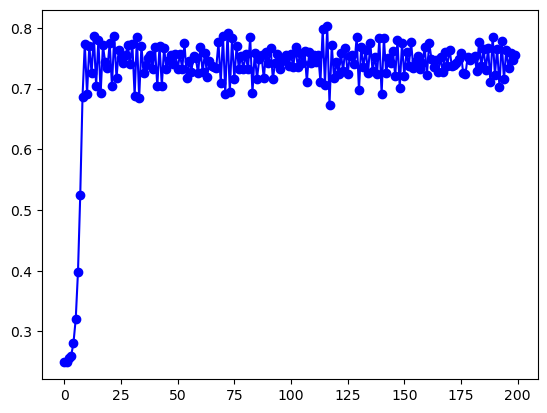

In [8]:
# Example usage:
c = 5.3
noise_std = 0.015  # Standard deviation of the additive noise

x_o = generate_ar1_time_series([c, noise_std])
plt.plot(x_o, label='Time Series Data', color='blue', marker='o', linestyle='-')

In [29]:
num_rounds = 7
# The specific observation we want to focus the inference on.

posteriors = []
proposal = prior

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=1000)

    # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:02<00:00, 466.52it/s]


 Neural network successfully converged after 245 epochs.

Drawing 1000 posterior samples: 1034it [00:00, 182876.25it/s]           
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:02<00:00, 478.40it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 96 epochs.

Drawing 1000 posterior samples: 1043it [00:00, 296727.88it/s]           
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:02<00:00, 474.91it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 97 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:02<00:00, 473.23it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:02<00:00, 472.94it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:02<00:00, 472.06it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:02<00:00, 475.24it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 55 epochs.

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 591371.73it/s]


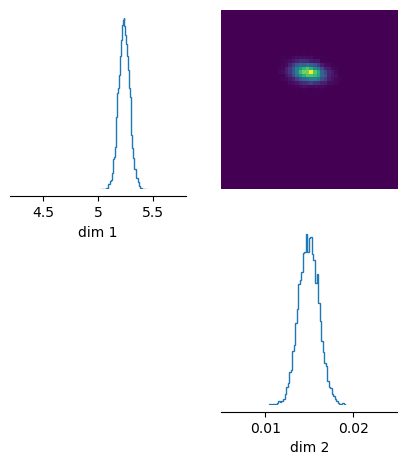

In [37]:
posterior_samples = posteriors[6].sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[4.2, 5.8], [0.005, 0.025]], figsize=(5, 5)
)

In [38]:
AR1PostSampleArray = posterior_samples.numpy()
np.savetxt("test.txt", AR1PostSampleArray, delimiter=',')

In [106]:
from torch.utils.data import DataLoader, TensorDataset

# Define the prior distribution
low = [4.2, 0.005]
high = [5.8, 0.025]

# Number of samples
num_samples = 1000

# Sample from the prior distribution
samples = np.random.uniform(low, high, size=(num_samples, len(low)))

generated_time_series = []

for params in samples:
    time_series = generate_ar1_time_series(params)
    generated_time_series.append(time_series)

time_series_tensors = torch.tensor(generated_time_series).double()

In [107]:
time_series_tensors.size()

torch.Size([1000, 200])

In [53]:
# Instantiate the Encoder network (assuming your actual instantiation is embedding_net)
embedding_net = Encoder(seq_len=200, encoded_space_dim=3, drop_p=0.5, act=nn.LeakyReLU)

# Load the learned weights (state_dict) if you have saved them during training
# Example: embedding_net.load_state_dict(torch.load('path/to/your/weights.pth'))

# Set the network to evaluation mode
embedding_net.eval()


Encoder(
  (first_block): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv1d(16, 16, kernel_size=(3,), stride=(1,))
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (second_block): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Conv1d(32, 3, kernel_size=(3,), stride=(1,))
    (7): AvgPool1d(kernel_size=(92,), stride=(92,), padding=(0,))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [78]:
embedding_net = embedding_net.double()


In [114]:
generated_summary_stats = []

for i in range(0,1000):
    summary_stats = embedding_net(time_series_tensors[i].unsqueeze(0))
    generated_summary_stats.append(summary_stats)

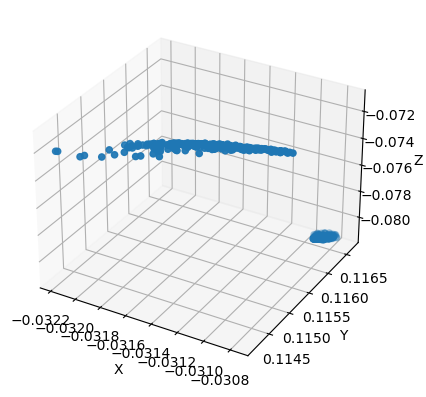

In [145]:
from mpl_toolkits.mplot3d import Axes3D

# Convert the list of tensors to a 2D NumPy array
tensor_array = torch.cat(generated_summary_stats, dim=1).detach().numpy()

# Plotting in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(tensor_array[0, :], tensor_array[1, :], tensor_array[2, :])

# ax.set_xlim([-0.05, -0.03])  # Set the X-axis scale
# ax.set_ylim([0.0, 0.15])    # Set the Y-axis scale
# ax.set_zlim([-0.09, -0.07])  # Set the Z-axis scale

# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()
